In [1]:
import numpy as np
from astropy.io import fits
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:

hdus = fits.open('delta.fits.gz')

In [3]:
print(len(hdus)-1, 'quasars in this file')

2659 quasars in this file


Text(0,0.5,'Comoving distance $\\chi(z)$')

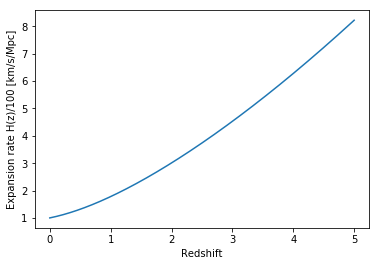

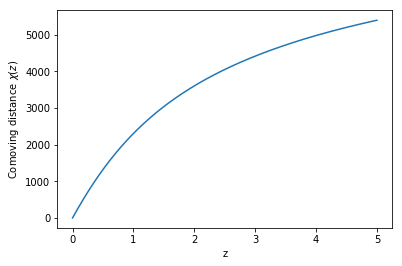

In [4]:
#-- Creating a table of z vs comoving distance in order to interpolate later for each forest

z_table = np.linspace(0, 5., 1000)
r_table = np.zeros(1000)

omega_m = 0.31
omega_l = 0.69

#-- Compute E(z) = H(z)/H_0 and plot it
E_z = np.sqrt(omega_m*(1+z_table)**3+omega_l)
plt.figure()
plt.plot(z_table, E_z)
plt.xlabel('Redshift')
plt.ylabel('Expansion rate H(z)/100 [km/s/Mpc]')

#-- Compute r_table and plot it
dz = z_table[1]-z_table[0]
for i in range(1, z_table.size):
    r_table[i] = np.sum( 3000/E_z[:i] )*dz
plt.figure()
plt.plot(z_table, r_table)
plt.xlabel('z')
plt.ylabel(r'Comoving distance $\chi(z)$')
    
    
    


In [5]:
#-- This function computes comoving distances by just interpolating over z_table and r_table computed above
def comoving_dist(loglam):
    wave = 10**loglam
    z = wave/1216 -1
    r_comov = np.interp(z, z_table, r_table)
    return r_comov
    

In [6]:
class qso:
    def __init__(self, hdu):
        self.ra = hdu.header['RA']
        self.dec = hdu.header['DEC']
        self.zqso = hdu.header['Z']
        self.loglam = hdu.data['LOGLAM']
        self.delta = hdu.data['DELTA']
        self.weight = hdu.data['WEIGHT']
        self.r_comov = comoving_dist(self.loglam)
        self.x_comov = self.r_comov*np.cos(self.dec)*np.cos(self.ra)
        self.y_comov = self.r_comov*np.cos(self.dec)*np.sin(self.ra)
        self.z_comov = self.r_comov*np.sin(self.dec)

In [7]:
#-- Just read one quasar for test, and do some plots
qso_example_a = qso(hdus[1])
qso_example_b = qso(hdus[28])

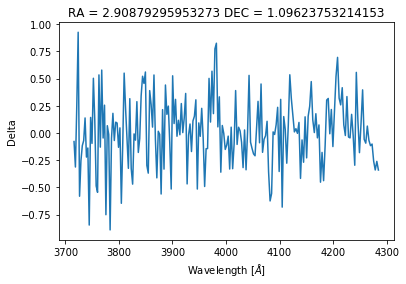

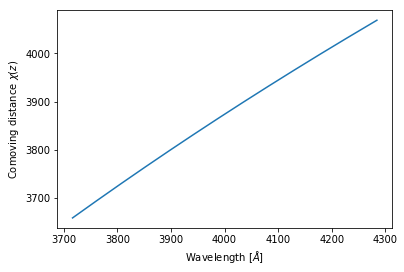

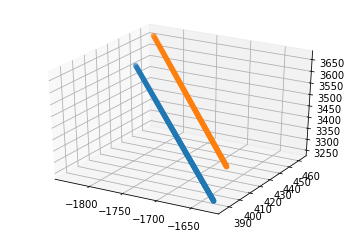

In [9]:
wave = 10**qso_example_a.loglam
plt.plot(wave, qso_example_a.delta)
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Delta')
plt.title(f'RA = {qso_example_a.ra} DEC = {qso_example_a.dec}')

plt.figure()
plt.plot(wave, qso_example_a.r_comov)
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Comoving distance $\chi(z)$')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(qso_example_a.x_comov, qso_example_a.y_comov, qso_example_a.z_comov, 'o')
ax.scatter(qso_example_b.x_comov, qso_example_b.y_comov, qso_example_b.z_comov, 'o')

In [34]:
rmax = 40.
nbins = 10

def is_close(qso1, qso2, rmax):
    rmin = np.min([qso1.r_comov[0], qso2.r_comov[0]])
    
    x1 = rmin*np.cos(qso1.dec)*np.cos(qso1.ra)
    y1 = rmin*np.cos(qso1.dec)*np.sin(qso1.ra)
    z1 = rmin*np.sin(qso1.dec)
    x2 = rmin*np.cos(qso2.dec)*np.cos(qso2.ra)
    y2 = rmin*np.cos(qso2.dec)*np.sin(qso2.ra)
    z2 = rmin*np.sin(qso2.dec)
    
    dist = np.sqrt( (x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
    if dist<rmax:
        return True
    else:
        return False
    
    

def get_xi_for_pair(qso1, qso2, verbose=False):
    x1, y1, z1 = qso1.x_comov, qso1.y_comov, qso1.z_comov
    x2, y2, z2 = qso2.x_comov, qso2.y_comov, qso2.z_comov

    #-- compute distance and product of deltas between all pixels
    #-- Here we use a trick to compute using one added dimension to array
    dist = np.sqrt( (x1-x2[:, None])**2 + (y1-y2[:, None])**2 + (z1-z2[:, None])**2)

    
    #-- Make matrix into 1D array
    dist = dist.ravel()
    r_bin = np.floor( dist/rmax*nbins).astype(int)
    
    #-- Check if there's any pair with separation less than rmax
    w_good = (r_bin<nbins)
    
    if sum(w_good)==0:
        if verbose:
            print('No pixels with separations less than', rmax)
            print('min sep = ', np.min(dist), 'max sep =', np.max(dist))
        return None
    
    w1d1w2d2 = qso1.delta*qso1.weight*qso2.delta[:, None]*qso2.weight[:, None]
    w1w2 = qso1.weight*qso2.weight[:, None]
    
    #-- Select just good pixels
    r_bin = r_bin[w_good]
    w1d1w2d2 = w1d1w2d2.ravel()[w_good]
    w1w2 = w1w2.ravel()[w_good]
    
    #-- Do the sum per bin
    sum_delta = np.bincount(r_bin, weights=w1d1w2d2, minlength=nbins)
    sum_weight = np.bincount(r_bin, weights=w1w2, minlength=nbins)
    sum_delta2 = np.bincount(r_bin, weights=w1d1w2d2**2, minlength=nbins)
    sum_n = np.bincount(r_bin, minlength=nbins)
    return sum_delta, sum_weight, sum_delta2, sum_n
        

In [29]:
print(is_close(qso_example_a, qso_example_b, rmax))

True


In [30]:
xi_pair = get_xi_for_pair(qso_example_a, qso_example_b)

In [31]:
print(xi_pair)

(array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,   209.57330649, -1822.94267638,
        -553.15372157,   -58.84488343]), array([     0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,  60889.54915189, 249185.65446367,
       141362.84337515, 123282.36837856]), array([     0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,  53591.51588295, 208236.88527212,
       116351.06938826, 108482.72762341]))


In [13]:
#-- Reading all quasars in delta.fits.gz
qsos = [qso(hdu) for hdu in hdus[1:]]

In [14]:
ra_all = np.array([qso.ra for qso in qsos])
dec_all = np.array([qso.dec for qso in qsos])

Selecting 107 that are close by for speed


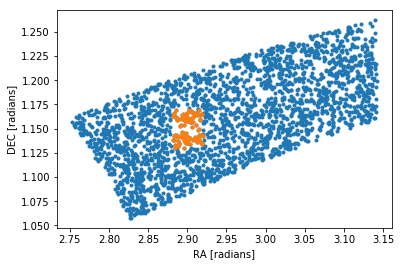

In [15]:
#-- Finding some quasars close together
plt.plot(ra_all, dec_all, '.')
plt.xlabel('RA [radians]')
plt.ylabel('DEC [radians]')
w = np.where((abs(ra_all-2.9)<0.02)&(abs(dec_all-1.15)<0.02))[0]
plt.plot(ra_all[w], dec_all[w], '.')

qsos_near = np.array(qsos)[w]
nqsos = len(qsos_near)
print(f'Selecting {nqsos} that are close by for speed')

In [35]:
#-- Doing double for loop over all pairs of qsos

r = (0.5+np.arange(nbins))*rmax/nbins
print(r)
sum_deltas_full = np.zeros(nbins)
sum_deltas2_full = np.zeros(nbins)
sum_weights_full = np.zeros(nbins)
sum_n_full = np.zeros(nbins)

qsos_list = qsos_near
#qsos_list = qsos

nqsos = len(qsos_list)

for i in range(nqsos):
    print(i, nqsos)
    for j in range(i+1, nqsos):
        qso1 = qsos_near[i]
        qso2 = qsos_near[j]
        if not is_close(qso1, qso2, rmax):
            continue
        xi_pair = get_xi_for_pair(qso1, qso2)
        if xi_pair is None:
            continue
        sum_deltas_full += xi_pair[0]
        sum_weights_full += xi_pair[1]
        sum_deltas2_full += xi_pair[2]
        sum_n_full += xi_pair[3]
        
        
xi = sum_deltas_full/sum_weights_full
var_xi = (sum_deltas2_full/sum_weights_full - xi**2)/sum_n_full


[ 2.  6. 10. 14. 18. 22. 26. 30. 34. 38.]
0 107
1 107
2 107
3 107
4 107
5 107
6 107
7 107
8 107
9 107
10 107
11 107
12 107
13 107
14 107
15 107
16 107
17 107
18 107
19 107
20 107
21 107
22 107
23 107
24 107
25 107
26 107
27 107
28 107
29 107
30 107
31 107
32 107
33 107
34 107
35 107
36 107
37 107
38 107
39 107
40 107
41 107
42 107
43 107
44 107
45 107
46 107
47 107
48 107
49 107
50 107
51 107
52 107
53 107
54 107
55 107
56 107
57 107
58 107
59 107
60 107
61 107
62 107
63 107
64 107
65 107
66 107
67 107
68 107
69 107
70 107
71 107
72 107
73 107
74 107
75 107
76 107
77 107
78 107
79 107
80 107
81 107
82 107
83 107
84 107
85 107
86 107
87 107
88 107
89 107
90 107
91 107
92 107
93 107
94 107
95 107
96 107
97 107
98 107
99 107
100 107
101 107
102 107
103 107
104 107
105 107
106 107


Text(0,0.5,'Correlation function')

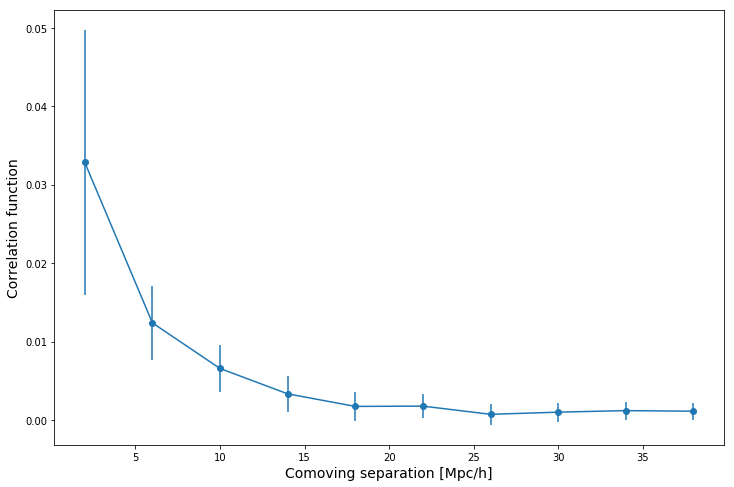

In [36]:
plt.figure(figsize=(12, 8))
plt.errorbar(r, xi, np.sqrt(var_xi), fmt='o-')
plt.xlabel('Comoving separation [Mpc/h]', fontsize=14)
plt.ylabel('Correlation function', fontsize=14)